# **通过Logistic Regression预测Titanic乘客是否能在事故中生还**
<font color='red'>请搜索"TODO"字样, 在有"TODO"字样的地方添加代码完成作业</font>

1. [导入工具库和数据](#t1.)
2. [查看缺失数据](#t2.)
    * 2.1. [年龄](#t2.1.)
    * 2.2. [仓位](#t2.2.)
    * 2.3. [登船地点](#t2.3.)
    * 2.4. [对数据进行调整](#t2.4.)
        * 2.4.1 [额外的变量](#t2.4.1.)
3. [数据分析](#t3.)
4. [Logistic Regression](#t4.)
    

<a id="t1."></a>
# 1. 导入工具库和数据

In [1]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #设置seaborn画图的背景为白色
sns.set(style="whitegrid", color_codes=True)

In [12]:
# 将数据读入 DataFrame
df = pd.read_csv("./titanic_data.csv")

# 预览数据
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S


In [13]:
print('数据集包含的数据个数 {}.'.format(df.shape[0]))

数据集包含的数据个数 1310.


<a id="t2."></a>
# 2. 查看缺失数据

In [14]:
# 查看数据集中各个特征缺失的情况
df.isnull().sum()

pclass         1
survived       1
name           1
sex            1
age          264
sibsp          1
parch          1
ticket         1
fare           2
cabin       1015
embarked       3
dtype: int64

<a id="t2.1."></a>
## 2.1.    年龄

In [15]:
# "age" 缺失的百分比 
print('"age" 缺失的百分比  %.2f%%' %((df['age'].isnull().sum()/df.shape[0])*100))

"age" 缺失的百分比  20.15%


约 20% 的乘客的年龄缺失了. 看一看年龄的分别情况.

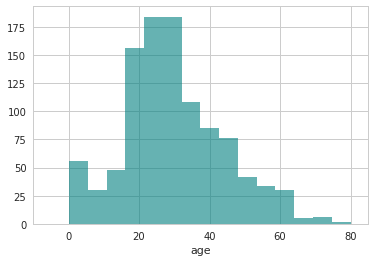

In [16]:
ax = df["age"].hist(bins=15, color='teal', alpha=0.6)
ax.set(xlabel='age')
plt.xlim(-10,85)
plt.show()

由于“年龄”的偏度不为0, 使用均值替代缺失值不是最佳选择, 这里可以选择使用中间值替代缺失值


<font color=red> 注: 在概率论和统计学中，偏度衡量实数随机变量概率分布的不对称性。偏度的值可以为正，可以为负或者甚至是无法定义。在数量上，偏度为负（负偏态）就意味着在概率密度函数左侧的尾部比右侧的长，绝大多数的值（不一定包括中位数在内）位于平均值的右侧。偏度为正（正偏态）就意味着在概率密度函数右侧的尾部比左侧的长，绝大多数的值（不一定包括中位数）位于平均值的左侧。偏度为零就表示数值相对均匀地分布在平均值的两侧，但不一定意味着其为对称分布。</font>

In [17]:
# 年龄的均值
print('The mean of "Age" is %.2f' %(df["age"].mean(skipna=True)))
# 年龄的中间值
print('The median of "Age" is %.2f' %(df["age"].median(skipna=True)))

The mean of "Age" is 29.88
The median of "Age" is 28.00


<a id="t2.2."></a>
## 2.2. 仓位

In [18]:
# 仓位缺失的百分比
print('"Cabin" 缺失的百分比 %.2f%%' %((df['cabin'].isnull().sum()/df.shape[0])*100))

"Cabin" 缺失的百分比 77.48%


约 77% 的乘客的仓位都是缺失的, 最佳的选择是不使用这个特征的值.

<a id="t2.3."></a>
## 2.3. 登船地点

In [19]:
# 登船地点的缺失率
print('"Embarked" 缺失的百分比 %.2f%%' %((df['embarked'].isnull().sum()/df.shape[0])*100))

"Embarked" 缺失的百分比 0.23%


只有 0.23% 的乘客的登船地点数据缺失, 可以使用众数替代缺失的值.

按照登船地点分组 (C = Cherbourg, Q = Queenstown, S = Southampton):
S    914
C    270
Q    123
Name: embarked, dtype: int64


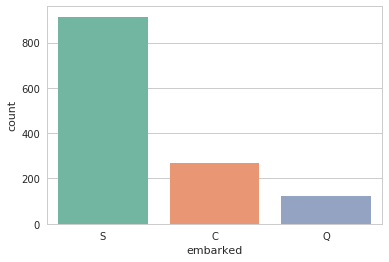

In [20]:
print('按照登船地点分组 (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(df['embarked'].value_counts())
sns.countplot(x='embarked', data=df, palette='Set2')
plt.show()

In [11]:
print('乘客登船地点的众数为 %s.' %df['embarked'].value_counts().idxmax())

乘客登船地点的众数为 S.


由于大多数人是在南安普顿(Southhampton)登船, 可以使用“S”替代缺失的数据值

<a id="t2.4."></a>
## 2.4. 根据缺失数据情况调整数据

基于以上分析, 我们进行如下调整:
* 如果一条数据的 "Age" 缺失, 使用年龄的中位数 28 替代.
* 如果一条数据的 "Embarked" 缺失, 使用登船地点的众数 “S” 替代.
* 由于太多乘客的 “Cabin” 数据缺失, 从所有数据中丢弃这个特征的值.

In [21]:
data = df.copy()
data["age"].fillna(df["age"].median(skipna=True), inplace=True)
data["embarked"].fillna(df['embarked'].value_counts().idxmax(), inplace=True)
data.drop('cabin', axis=1, inplace=True)

# 按照以上处理的方式, 处理仍然存在缺失数据的情况
TODO:

In [106]:
miss_col = data.isnull().sum()[data.isnull().sum()>0].index.tolist()  # 所有缺失字段
miss_col.remove('name')
miss_col.remove('ticket')

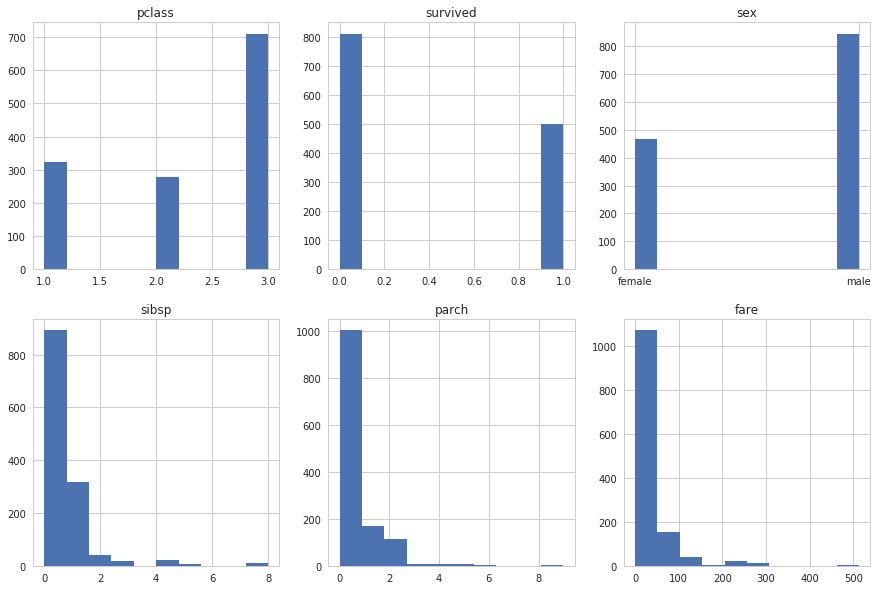

In [111]:
%matplotlib inline


fig, axs = plt.subplots(2, 3, figsize=(15,10))

for idx, col in enumerate(miss_col):
    pos_r = idx // 3
    pos_c = idx % 3
    ax = axs[pos_r,pos_c]
    ax.hist(data[col].dropna())
    ax.set_title(col)

In [113]:
for col in ['pclass','survived','sex']:
    data[col].fillna(data[col].value_counts().idxmax(), inplace=True)

In [114]:
for col in ['sibsp','parch','fare']:
    data[col].fillna(data[col].median(), inplace=True)

In [115]:
# 预览调整过的数据
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,S
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,S
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,S
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,S
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,S


### 查看年龄在调整前后的分布

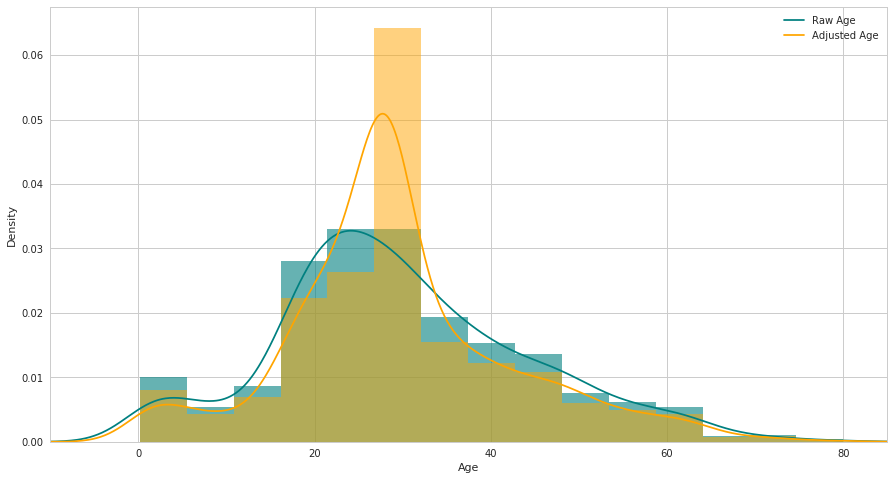

In [116]:
plt.figure(figsize=(15,8))
ax = df["age"].hist(bins=15, normed=True, stacked=True, color='teal', alpha=0.6)
df["age"].plot(kind='density', color='teal')
ax = data["age"].hist(bins=15, normed=True, stacked=True, color='orange', alpha=0.5)
data["age"].plot(kind='density', color='orange')
ax.legend(['Raw Age', 'Adjusted Age'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

<a id="t2.4.1."></a>
## 2.4.1. 其它特征的处理

数据中的两个特征 “sibsp” (一同登船的兄弟姐妹或者配偶数量)与“parch”(一同登船的父母或子女数量)都是代表是否有同伴同行. 为了预防这两个特征具有多重共线性, 我们可以将这两个变量转为一个变量 “TravelAlone” (是否独自一人成行)


<font color='red'>注: 多重共线性(multicollinearity)是指多变量线性回归中，变量之间由于存在高度相关关系而使回归估计不准确。比如虚拟变量陷阱（英语：Dummy variable trap）即有可能触发多重共线性问题。</font>

In [117]:
## 创建一个新的变量'TravelAlone'记录是否独自成行, 丢弃“sibsp” (一同登船的兄弟姐妹或者配偶数量)与“parch”(一同登船的父母或子女数量)
data['TravelAlone']=np.where((data["sibsp"]+data["parch"])>0, 0, 1)
data.drop('sibsp', axis=1, inplace=True)
data.drop('parch', axis=1, inplace=True)

对类别变量(categorical variables)使用独热编码(One-Hot Encoding), 将字符串类别转换为数值

In [118]:
# 对 Embarked","Sex"进行独热编码, 丢弃 'name', 'ticket'
final =pd.get_dummies(data, columns=["embarked","sex"])
final.drop('name', axis=1, inplace=True)
final.drop('ticket', axis=1, inplace=True)

final.head()

,pclass,survived,age,fare,TravelAlone,embarked_C,embarked_Q,embarked_S,sex_female,sex_male
0,1.0,1.0,29.0000,211.3375,1,0,0,1,1,0
1,1.0,1.0,0.9167,151.5500,0,0,0,1,0,1
2,1.0,0.0,2.0000,151.5500,0,0,0,1,1,0
3,1.0,0.0,30.0000,151.5500,0,0,0,1,0,1
4,1.0,0.0,25.0000,151.5500,0,0,0,1,1,0


<a id="t3."></a>
# 3. 数据分析

<a id="t3.1."></a>
## 3.1. 年龄

/Users/yuanyuan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


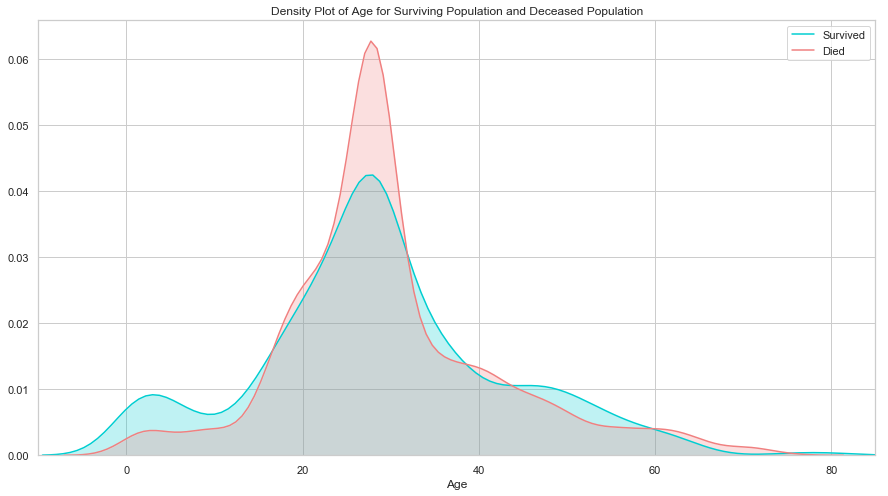

In [18]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final["age"][final.survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final["age"][final.survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

### 生还与遇难群体的分布相似, 唯一大的区别是生还群体中用一部分低年龄的乘客. 说明当时的人预先保留了孩子的生还机会.


<a id="t3.2."></a>
## 3.2. 票价

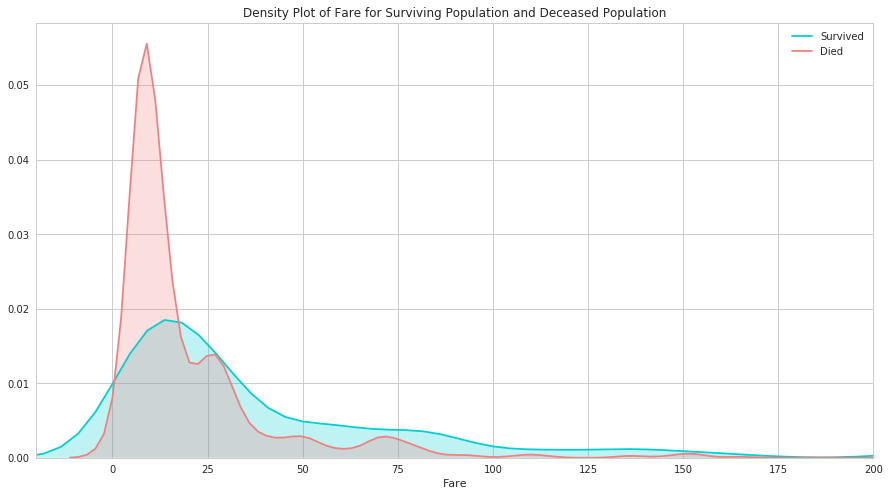

In [119]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final["fare"][final.survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final["fare"][final.survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

生还与遇难群体的票价分布差异比较大, 说明这个特征对预测乘客是否生还非常重要. 票价和仓位相关, 也许是仓位影响了逃生的效果, 我们接下来看仓位的分析.

<a id="t3.3."></a>
## 3.3. 仓位

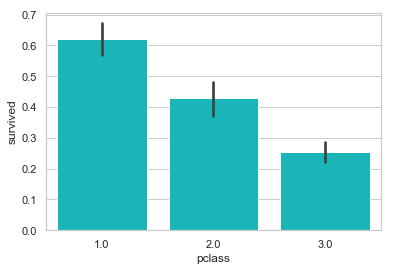

In [20]:
sns.barplot('pclass', 'survived', data=df, color="darkturquoise")
plt.show()

如我们所料, 一等舱的乘客生还几率最高.

<a id="t3.4."></a>
## 3.4. 登船地点

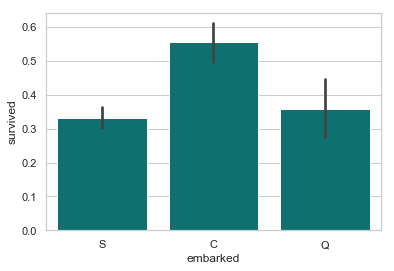

In [21]:
sns.barplot('embarked', 'survived', data=df, color="teal")
plt.show()

从法国 Cherbourge 登录的乘客生还率最高

<a id="t3.5."></a>
## 3.5. 是否独自成行

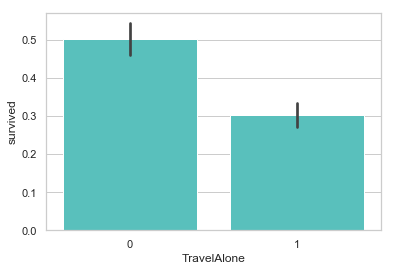

In [22]:
sns.barplot('TravelAlone', 'survived', data=final, color="mediumturquoise")
plt.show()

独自成行的乘客生还率比较低. 当时的年代, 大多数独自成行的乘客为男性居多.

<a id="t3.6."></a>
## 3.6. 性别

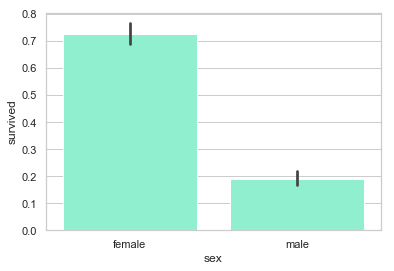

In [23]:
sns.barplot('sex', 'survived', data=df, color="aquamarine")
plt.show()

很明显, 女性的生还率比较高

<a id="t4."></a>
# 4. 使用Logistic Regression做预测


### 将数据集分为训练和测试数据集用于检测模型效果

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 使用如下特征做预测
cols = ["age","fare","TravelAlone","pclass","embarked_C","embarked_S","sex_male"] 

# 创建 X (特征) 和 y (类别标签)
X = final[cols]
y = final['survived']

# 将 X 和 y 分为两个部分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# 检测 logistic regression 模型的性能
# TODO 添加代码:
# 1.训练模型,  
reg = LogisticRegression(random_state=22)
reg.fit(X_train, y_train)

# 2.根据模型, 以 X_test 为输入, 生成变量 y_pred
y_pred = reg.predict(X_test)
print('Train/Test split results:')
print("准确率为 %2.3f" % accuracy_score(y_test, y_pred))


Train/Test split results:
准确率为 0.828


In [127]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l1','l2'],
    'class_weight': ['balanced',None],
    'C': np.arange(0.1,2,0.2),
    'tol': np.arange(1e-5,1e-3,2e-4)
}

grid_search = GridSearchCV(LogisticRegression(random_state=22), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Test set score:{:.3f}".format(grid_search.score(X_test,y_test)))
print("Best parameters:{}".format(grid_search.best_params_))
print("Best score on train set:{:.2f}".format(grid_search.best_score_))

Test set score:0.828
Best parameters:{'class_weight': None, 'C': 0.30000000000000004, 'tol': 1.0000000000000001e-05, 'penalty': 'l1'}
Best score on train set:0.77
